In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, \
RandomizedSearchCV
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, precision_score, recall_score,\
confusion_matrix, roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve, auc

import pandas_profiling

warnings.filterwarnings('ignore')
%matplotlib inline

df = pd.read_csv('data/unclean_season_data.csv').iloc[:,1:]
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


# Merge data and clean a bit

In [2]:
games_df = df.merge(df, left_on=['Opp', 'Season', 'Date'], right_on=['Team', 'Season', 'Date'], how='left',\
                   suffixes=('_A', '_B'))

In [3]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28756 entries, 0 to 28755
Data columns (total 88 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   G_A         26236 non-null  float64
 1   Date        26236 non-null  object 
 2    _A         13118 non-null  object 
 3   Opp_A       26236 non-null  object 
 4   W/L_A       26236 non-null  object 
 5   Tm_A        26236 non-null  float64
 6   Opp.1_A     26236 non-null  float64
 7   FG_A        26236 non-null  float64
 8   FGA_A       26236 non-null  float64
 9   FG%_A       26236 non-null  float64
 10  3P_A        26236 non-null  float64
 11  3PA_A       26236 non-null  float64
 12  3P%_A       26236 non-null  float64
 13  FT_A        26236 non-null  float64
 14  FTA_A       26236 non-null  float64
 15  FT%_A       26236 non-null  float64
 16  ORB_A       26236 non-null  float64
 17  TRB_A       26236 non-null  float64
 18  AST_A       26236 non-null  float64
 19  STL_A       26236 non-nul

In [4]:
games_df.head()

,G_A,Date,_A,Opp_A,W/L_A,Tm_A,Opp.1_A,FG_A,FGA_A,FG%_A,3P_A,3PA_A,3P%_A,FT_A,FTA_A,FT%_A,ORB_A,TRB_A,AST_A,STL_A,BLK_A,TOV_A,PF_A,ORtg_A,DRtg_A,Pace_A,FTr_A,3PAr_A,TS%_A,TRB%_A,AST%_A,STL%_A,BLK%_A,.1_A,eFG%_A,TOV%_A,ORB%_A,FT/FGA_A,.2_A,eFG%.1_A,TOV%.1_A,DRB%_A,FT/FGA.1_A,Team_A,Season,G_B,_B,Opp_B,W/L_B,Tm_B,Opp.1_B,FG_B,FGA_B,FG%_B,3P_B,3PA_B,3P%_B,FT_B,FTA_B,FT%_B,ORB_B,TRB_B,AST_B,STL_B,BLK_B,TOV_B,PF_B,ORtg_B,DRtg_B,Pace_B,FTr_B,3PAr_B,TS%_B,TRB%_B,AST%_B,STL%_B,BLK%_B,.1_B,eFG%_B,TOV%_B,ORB%_B,FT/FGA_B,.2_B,eFG%.1_B,TOV%.1_B,DRB%_B,FT/FGA.1_B,Team_B
0,1.0,2009-10-28,NaN,IND,W,120.0,109.0,46.0,87.0,0.529,7.0,12.0,0.583,21.0,29.0,0.724,8.0,35.0,30.0,16.0,6.0,10.0,25.0,119.0,108.1,100.8,0.333,0.138,0.601,46.7,65.2,15.9,10.9,NaN,0.569,9.1,19.0,0.241,NaN,0.603,22.9,81.8,0.288,ATL,2010,1.0,@,ATL,L,109.0,120.0,39.0,73.0,0.534,10.0,18.0,0.556,21.0,25.0,0.840,6.0,40.0,23.0,1.0,4.0,25.0,26.0,108.1,119.0,100.8,0.342,0.247,0.649,53.3,59.0,1.0,5.3,NaN,0.603,22.9,18.2,0.288,NaN,0.569,9.1,81.0,0.241,IND
1,2.0,2009-10-30,NaN,WAS,W,100.0,89.0,32.0,78.0,0.410,5.0,20.0,0.250,31.0,34.0,0.912,11.0,47.0,18.0,5.0,7.0,12.0,24.0,108.5,96.6,92.1,0.436,0.256,0.538,54.0,56.3,5.4,10.6,NaN,0.442,11.4,25.6,0.397,NaN,0.475,13.6,81.8,0.177,ATL,2010,2.0,@,ATL,L,89.0,100.0,35.0,79.0,0.443,5.0,13.0,0.385,14.0,22.0,0.636,8.0,40.0,19.0,5.0,5.0,14.0,23.0,96.6,108.5,92.1,0.278,0.165,0.502,46.0,54.3,5.4,8.6,NaN,0.475,13.6,18.2,0.177,NaN,0.442,11.4,74.4,0.397,WAS
2,3.0,2009-11-01,@,LAL,L,110.0,118.0,40.0,89.0,0.449,7.0,23.0,0.304,23.0,26.0,0.885,14.0,40.0,21.0,8.0,3.0,19.0,21.0,109.4,117.4,100.5,0.292,0.258,0.548,48.8,52.5,8.0,4.2,NaN,0.489,15.9,31.1,0.258,NaN,0.557,13.3,70.3,0.241,ATL,2010,3.0,NaN,ATL,W,118.0,110.0,46.0,87.0,0.529,5.0,15.0,0.333,21.0,25.0,0.840,11.0,42.0,26.0,14.0,6.0,15.0,20.0,117.4,109.4,100.5,0.287,0.172,0.602,51.2,56.5,13.9,9.1,NaN,0.557,13.3,29.7,0.241,NaN,0.489,15.9,68.9,0.258,LAL
3,4.0,2009-11-03,@,POR,W,97.0,91.0,37.0,80.0,0.463,5.0,15.0,0.333,18.0,22.0,0.818,11.0,46.0,21.0,4.0,7.0,11.0,15.0,111.6,104.7,86.9,0.275,0.188,0.541,56.1,56.8,4.6,10.9,NaN,0.494,10.9,29.7,0.225,NaN,0.459,8.0,77.8,0.153,ATL,2010,5.0,NaN,ATL,L,91.0,97.0,36.0,85.0,0.424,6.0,21.0,0.286,13.0,16.0,0.813,10.0,36.0,22.0,7.0,4.0,8.0,20.0,104.7,111.6,86.9,0.188,0.247,0.494,43.9,61.1,8.1,6.2,NaN,0.459,8.0,22.2,0.153,NaN,0.494,10.9,70.3,0.225,POR
4,5.0,2009-11-04,@,SAC,W,113.0,105.0,46.0,85.0,0.541,6.0,16.0,0.375,15.0,19.0,0.789,12.0,47.0,17.0,2.0,10.0,16.0,20.0,120.6,112.1,93.7,0.224,0.188,0.605,52.2,37.0,2.1,12.3,NaN,0.576,14.6,33.3,0.176,NaN,0.443,6.1,64.8,0.208,ATL,2010,5.0,NaN,ATL,L,105.0,113.0,40.0,96.0,0.417,5.0,15.0,0.333,20.0,27.0,0.741,19.0,43.0,18.0,11.0,2.0,7.0,19.0,112.1,120.6,93.7,0.281,0.156,0.487,47.8,45.0,11.7,2.9,NaN,0.443,6.1,35.2,0.208,NaN,0.576,14.6,66.7,0.176,SAC


In [5]:
games_df.rename(columns={'eFG%.1_A':'D-eFG%_A', 'TOV%.1_A':'D-TOV%_A', 'FT/FGA.1_A':'D-FT/FGA_A',\
                  'Tm_A':'PTS_A', 'Opp.1_A':'OppPTS', 'W/L_A':'A_Win', 'eFG%.1_B': 'D-eFG%_B',\
                        'TOV%.1_B': 'D-TOV%_B', 'FT/FGA.1_B':'D-FT/FGA_B'}, inplace=True)

In [6]:
games_df.rename(columns={games_df.columns[2]:'Home'}, inplace=True)

In [7]:
games_df.head()

,G_A,Date,Home,Opp_A,A_Win,PTS_A,OppPTS,FG_A,FGA_A,FG%_A,3P_A,3PA_A,3P%_A,FT_A,FTA_A,FT%_A,ORB_A,TRB_A,AST_A,STL_A,BLK_A,TOV_A,PF_A,ORtg_A,DRtg_A,Pace_A,FTr_A,3PAr_A,TS%_A,TRB%_A,AST%_A,STL%_A,BLK%_A,.1_A,eFG%_A,TOV%_A,ORB%_A,FT/FGA_A,.2_A,D-eFG%_A,D-TOV%_A,DRB%_A,D-FT/FGA_A,Team_A,Season,G_B,_B,Opp_B,W/L_B,Tm_B,Opp.1_B,FG_B,FGA_B,FG%_B,3P_B,3PA_B,3P%_B,FT_B,FTA_B,FT%_B,ORB_B,TRB_B,AST_B,STL_B,BLK_B,TOV_B,PF_B,ORtg_B,DRtg_B,Pace_B,FTr_B,3PAr_B,TS%_B,TRB%_B,AST%_B,STL%_B,BLK%_B,.1_B,eFG%_B,TOV%_B,ORB%_B,FT/FGA_B,.2_B,D-eFG%_B,D-TOV%_B,DRB%_B,D-FT/FGA_B,Team_B
0,1.0,2009-10-28,NaN,IND,W,120.0,109.0,46.0,87.0,0.529,7.0,12.0,0.583,21.0,29.0,0.724,8.0,35.0,30.0,16.0,6.0,10.0,25.0,119.0,108.1,100.8,0.333,0.138,0.601,46.7,65.2,15.9,10.9,NaN,0.569,9.1,19.0,0.241,NaN,0.603,22.9,81.8,0.288,ATL,2010,1.0,@,ATL,L,109.0,120.0,39.0,73.0,0.534,10.0,18.0,0.556,21.0,25.0,0.840,6.0,40.0,23.0,1.0,4.0,25.0,26.0,108.1,119.0,100.8,0.342,0.247,0.649,53.3,59.0,1.0,5.3,NaN,0.603,22.9,18.2,0.288,NaN,0.569,9.1,81.0,0.241,IND
1,2.0,2009-10-30,NaN,WAS,W,100.0,89.0,32.0,78.0,0.410,5.0,20.0,0.250,31.0,34.0,0.912,11.0,47.0,18.0,5.0,7.0,12.0,24.0,108.5,96.6,92.1,0.436,0.256,0.538,54.0,56.3,5.4,10.6,NaN,0.442,11.4,25.6,0.397,NaN,0.475,13.6,81.8,0.177,ATL,2010,2.0,@,ATL,L,89.0,100.0,35.0,79.0,0.443,5.0,13.0,0.385,14.0,22.0,0.636,8.0,40.0,19.0,5.0,5.0,14.0,23.0,96.6,108.5,92.1,0.278,0.165,0.502,46.0,54.3,5.4,8.6,NaN,0.475,13.6,18.2,0.177,NaN,0.442,11.4,74.4,0.397,WAS
2,3.0,2009-11-01,@,LAL,L,110.0,118.0,40.0,89.0,0.449,7.0,23.0,0.304,23.0,26.0,0.885,14.0,40.0,21.0,8.0,3.0,19.0,21.0,109.4,117.4,100.5,0.292,0.258,0.548,48.8,52.5,8.0,4.2,NaN,0.489,15.9,31.1,0.258,NaN,0.557,13.3,70.3,0.241,ATL,2010,3.0,NaN,ATL,W,118.0,110.0,46.0,87.0,0.529,5.0,15.0,0.333,21.0,25.0,0.840,11.0,42.0,26.0,14.0,6.0,15.0,20.0,117.4,109.4,100.5,0.287,0.172,0.602,51.2,56.5,13.9,9.1,NaN,0.557,13.3,29.7,0.241,NaN,0.489,15.9,68.9,0.258,LAL
3,4.0,2009-11-03,@,POR,W,97.0,91.0,37.0,80.0,0.463,5.0,15.0,0.333,18.0,22.0,0.818,11.0,46.0,21.0,4.0,7.0,11.0,15.0,111.6,104.7,86.9,0.275,0.188,0.541,56.1,56.8,4.6,10.9,NaN,0.494,10.9,29.7,0.225,NaN,0.459,8.0,77.8,0.153,ATL,2010,5.0,NaN,ATL,L,91.0,97.0,36.0,85.0,0.424,6.0,21.0,0.286,13.0,16.0,0.813,10.0,36.0,22.0,7.0,4.0,8.0,20.0,104.7,111.6,86.9,0.188,0.247,0.494,43.9,61.1,8.1,6.2,NaN,0.459,8.0,22.2,0.153,NaN,0.494,10.9,70.3,0.225,POR
4,5.0,2009-11-04,@,SAC,W,113.0,105.0,46.0,85.0,0.541,6.0,16.0,0.375,15.0,19.0,0.789,12.0,47.0,17.0,2.0,10.0,16.0,20.0,120.6,112.1,93.7,0.224,0.188,0.605,52.2,37.0,2.1,12.3,NaN,0.576,14.6,33.3,0.176,NaN,0.443,6.1,64.8,0.208,ATL,2010,5.0,NaN,ATL,L,105.0,113.0,40.0,96.0,0.417,5.0,15.0,0.333,20.0,27.0,0.741,19.0,43.0,18.0,11.0,2.0,7.0,19.0,112.1,120.6,93.7,0.281,0.156,0.487,47.8,45.0,11.7,2.9,NaN,0.443,6.1,35.2,0.208,NaN,0.576,14.6,66.7,0.176,SAC


In [8]:
# Drop the extra/pointless columns
# Drop points and opponent points columns for fear of multicolinearity
games_df.drop(games_df.columns[[0, 3, 33, 38, 77, 82, 5, 6, 7, 8, 9, 10, \
                                11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,\
                               45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,\
                               58, 59, 60, 61, 62, 63, 64, 65, 66,
                               39, 40, 41, 42, 83, 84, 85, 86]], axis=1, inplace=True)

In [9]:
# Fill the home/away column with 1s and 0s
games_df['Home'] = games_df['Home'].fillna(1)

In [10]:
# Drop the extra rows with NaN
games_df.dropna(axis=0, inplace=True)

In [11]:
# Change the Home and Wins columns to display a 1 for home and a 1 for win
games_df.replace(to_replace = '@', value = '0', inplace=True)

In [12]:
games_df.replace(to_replace={'A_Win':{'W':1, 'L':0}}, inplace = True)

In [13]:
# Convert dtype from object to Boolean
games_df['Home'] = games_df['Home'].astype(dtype=int)
games_df['A_Win'] = games_df['A_Win'].astype(dtype=int)

In [14]:
games_df.head(20)

,Date,Home,A_Win,ORtg_A,DRtg_A,Pace_A,FTr_A,3PAr_A,TS%_A,TRB%_A,AST%_A,STL%_A,BLK%_A,eFG%_A,TOV%_A,ORB%_A,FT/FGA_A,Team_A,Season,ORtg_B,DRtg_B,Pace_B,FTr_B,3PAr_B,TS%_B,TRB%_B,AST%_B,STL%_B,BLK%_B,eFG%_B,TOV%_B,ORB%_B,FT/FGA_B,Team_B
0,2009-10-28,1,1,119.0,108.1,100.8,0.333,0.138,0.601,46.7,65.2,15.9,10.9,0.569,9.1,19.0,0.241,ATL,2010,108.1,119.0,100.8,0.342,0.247,0.649,53.3,59.0,1.0,5.3,0.603,22.9,18.2,0.288,IND
1,2009-10-30,1,1,108.5,96.6,92.1,0.436,0.256,0.538,54.0,56.3,5.4,10.6,0.442,11.4,25.6,0.397,ATL,2010,96.6,108.5,92.1,0.278,0.165,0.502,46.0,54.3,5.4,8.6,0.475,13.6,18.2,0.177,WAS
2,2009-11-01,0,0,109.4,117.4,100.5,0.292,0.258,0.548,48.8,52.5,8.0,4.2,0.489,15.9,31.1,0.258,ATL,2010,117.4,109.4,100.5,0.287,0.172,0.602,51.2,56.5,13.9,9.1,0.557,13.3,29.7,0.241,LAL
3,2009-11-03,0,1,111.6,104.7,86.9,0.275,0.188,0.541,56.1,56.8,4.6,10.9,0.494,10.9,29.7,0.225,ATL,2010,104.7,111.6,86.9,0.188,0.247,0.494,43.9,61.1,8.1,6.2,0.459,8.0,22.2,0.153,POR
4,2009-11-04,0,1,120.6,112.1,93.7,0.224,0.188,0.605,52.2,37.0,2.1,12.3,0.576,14.6,33.3,0.176,ATL,2010,112.1,120.6,93.7,0.281,0.156,0.487,47.8,45.0,11.7,2.9,0.443,6.1,35.2,0.208,SAC
5,2009-11-06,0,0,90.7,112.6,91.5,0.277,0.193,0.446,38.5,30.3,7.7,16.9,0.410,7.0,13.7,0.181,ATL,2010,112.6,90.7,91.5,0.217,0.217,0.566,61.5,61.5,2.2,10.4,0.536,14.2,30.0,0.169,CHA
6,2009-11-07,1,1,131.5,105.2,95.1,0.345,0.218,0.624,55.0,66.7,4.2,13.2,0.563,7.4,23.5,0.310,ATL,2010,105.2,131.5,95.1,0.526,0.128,0.521,45.0,53.1,5.3,5.9,0.423,9.4,21.7,0.436,DEN
7,2009-11-11,0,1,117.3,103.9,97.2,0.296,0.160,0.623,51.9,52.3,7.2,4.9,0.580,14.1,23.1,0.247,ATL,2010,103.9,117.3,97.2,0.212,0.282,0.543,48.1,45.0,7.2,2.9,0.500,14.7,21.4,0.188,NYK
8,2009-11-13,0,1,110.7,98.2,87.6,0.274,0.179,0.515,61.8,50.0,8.0,10.3,0.476,12.1,41.0,0.202,ATL,2010,98.2,110.7,87.6,0.260,0.205,0.529,38.2,55.6,6.8,5.8,0.500,15.6,16.2,0.178,BOS
9,2009-11-14,1,1,124.6,100.9,97.1,0.330,0.227,0.600,53.9,56.3,10.3,4.7,0.585,12.2,38.6,0.205,ATL,2010,100.9,124.6,97.1,0.198,0.297,0.495,46.1,62.5,7.2,4.4,0.478,13.9,31.1,0.121,NOH


In [15]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26236 entries, 0 to 28755
Data columns (total 34 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      26236 non-null  object 
 1   Home      26236 non-null  int64  
 2   A_Win     26236 non-null  int64  
 3   ORtg_A    26236 non-null  float64
 4   DRtg_A    26236 non-null  float64
 5   Pace_A    26236 non-null  float64
 6   FTr_A     26236 non-null  float64
 7   3PAr_A    26236 non-null  float64
 8   TS%_A     26236 non-null  float64
 9   TRB%_A    26236 non-null  float64
 10  AST%_A    26236 non-null  float64
 11  STL%_A    26236 non-null  float64
 12  BLK%_A    26236 non-null  float64
 13  eFG%_A    26236 non-null  float64
 14  TOV%_A    26236 non-null  float64
 15  ORB%_A    26236 non-null  float64
 16  FT/FGA_A  26236 non-null  float64
 17  Team_A    26236 non-null  object 
 18  Season    26236 non-null  int64  
 19  ORtg_B    26236 non-null  float64
 20  DRtg_B    26236 non-null  fl

## Create a covariance matrix

In [16]:
# Create a df for the covariance matrix, without date and opponent
cov_df = games_df.drop(columns=['Date', 'Team_A', 'Season', 'Team_B', 'Home'])

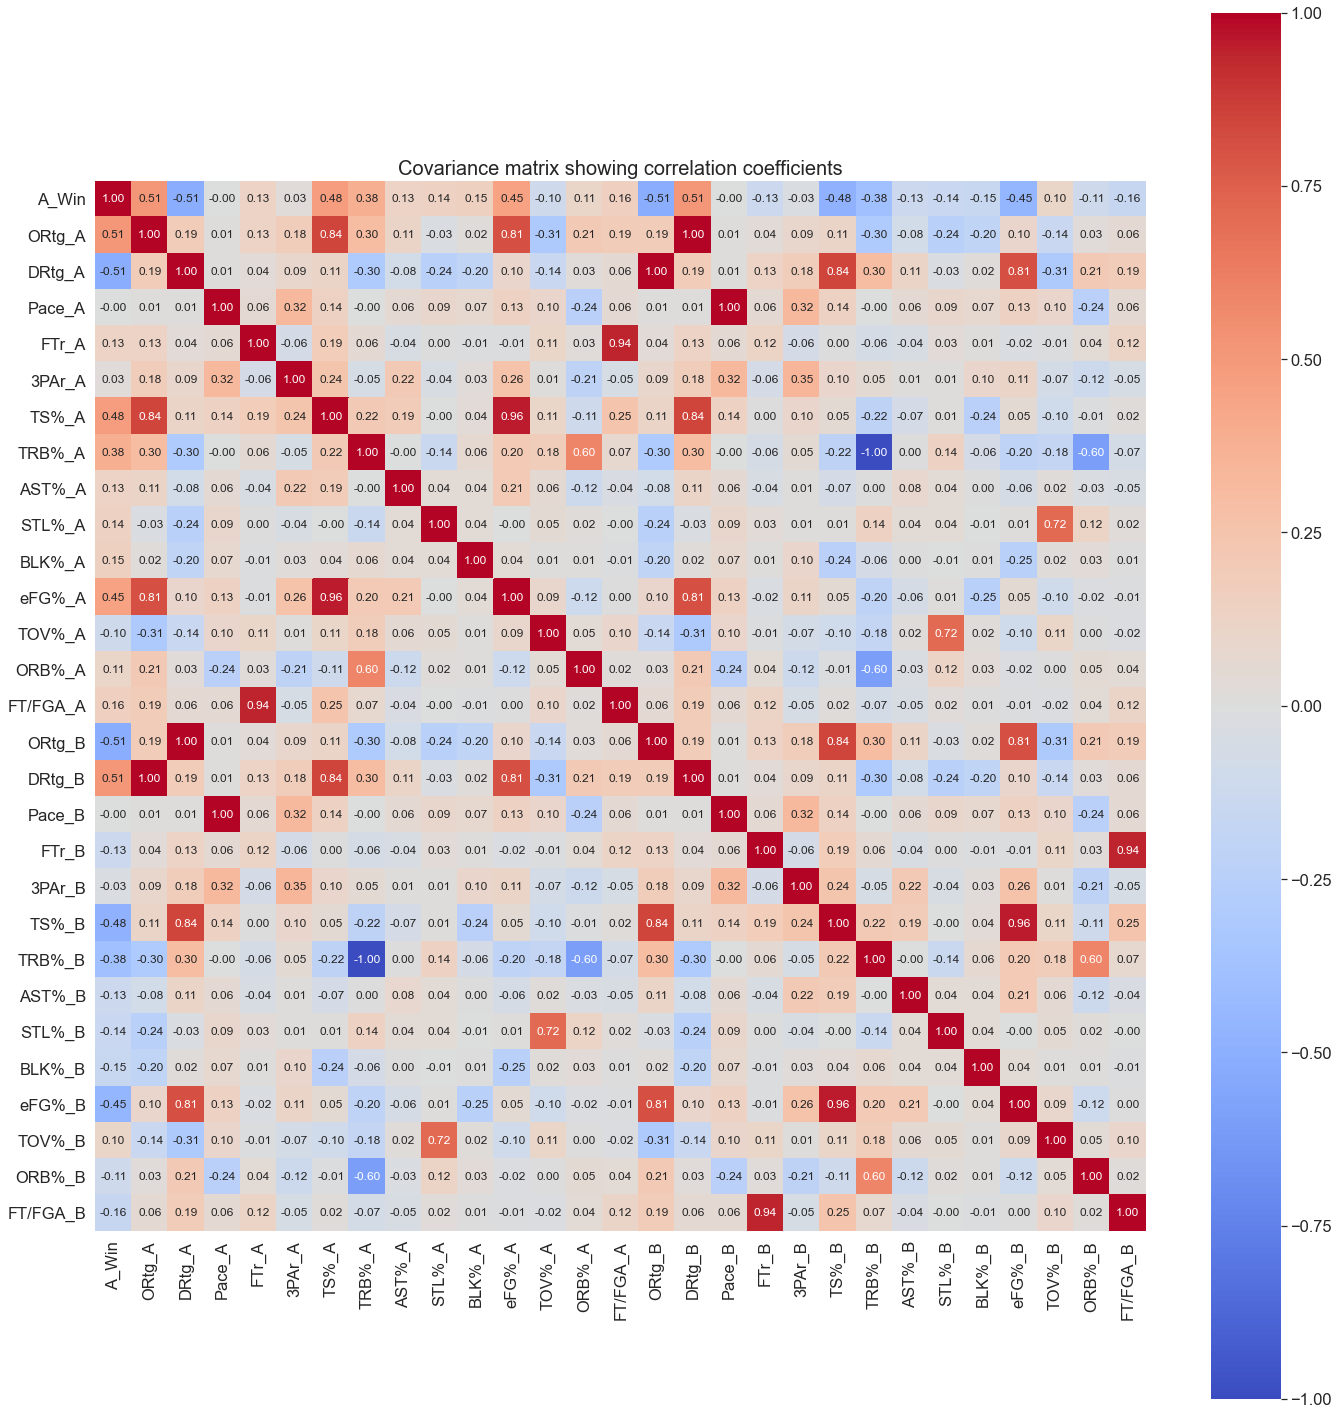

<Figure size 432x288 with 0 Axes>

In [17]:
# Advanced covariance matrix

stdsc = StandardScaler() 
X_std = stdsc.fit_transform(cov_df.values)
cov_mat =np.cov(X_std.T)
plt.figure(figsize=(20,20))
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 cmap='coolwarm',                 
                 yticklabels=cov_df.columns,
                 xticklabels=cov_df.columns)
plt.title('Covariance matrix showing correlation coefficients', size = 20)
plt.tight_layout()
plt.show()

plt.savefig("two_team_covariance.png")

## Testing out a vanilla classifier

In [57]:
y = games_df['A_Win']
X = games_df.drop(columns=['A_Win', 'Date', 'Team_A', 'Season', 'Team_B', 'Home'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [58]:
classifiers = {
    'Logistic Regression' : LogisticRegression(), 
    'Random Forest' : RandomForestClassifier(), 
    'Support Vector Machine' : SVC(), 
    'K-Nearest Neighbors' : KNeighborsClassifier(), 
    'Decision Tree' : DecisionTreeClassifier(), 
    'XGBoost' : XGBClassifier()
}

In [59]:
# Use a loop to go through each vanilla model
results = pd.DataFrame(columns= ['Train_accuracy', 'Test_accuracy', 'F1_score', 
                                'False_Negative', 'True_Positive'])

for key, value in classifiers.items():
    #fit models
    value.fit(X_train, y_train)
    train_pred = value.predict(X_train)
    y_pred = value.predict(X_test)
    
    # get accuracy, f1 score
    train_acc = accuracy_score(y_train, train_pred) * 100
    test_acc = accuracy_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred)
    
    #get false neg and true positive
    cm = confusion_matrix(y_test, y_pred)
    FN = cm[1][0]
    TP = cm[1][1]
    
    # add measurements to datafram
    results.loc[key] = [round(train_acc, 2), round(test_acc, 2), 
                        round(f1, 2), round(FN, 0), round(TP, 0)]

In [60]:
results.sort_values(by= ['F1_score', 'False_Negative'], ascending= False)



,Train_accuracy,Test_accuracy,F1_score,False_Negative,True_Positive
Decision Tree,100.00,99.63,1.00,10.0,3289.0
Random Forest,100.00,99.79,1.00,5.0,3294.0
Support Vector Machine,99.98,99.97,1.00,2.0,3297.0
XGBoost,100.00,99.89,1.00,2.0,3297.0
Logistic Regression,100.00,100.00,1.00,0.0,3299.0
K-Nearest Neighbors,98.69,97.29,0.97,80.0,3219.0


In [22]:
#Construct a decision tree
d_tree = DecisionTreeClassifier()
d_tree.fit(X_train, y_train)
d_tree.feature_importances_

array([2.81213454e-01, 4.34634316e-01, 0.00000000e+00, 2.62338035e-04,
       0.00000000e+00, 6.64723359e-04, 2.23476519e-05, 8.23169158e-04,
       1.99717437e-04, 1.62627055e-04, 4.03903543e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.20158822e-02, 1.98294643e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.95981155e-04,
       0.00000000e+00, 0.00000000e+00, 1.98896850e-04, 3.96646273e-05,
       3.54940002e-04, 0.00000000e+00, 1.35522546e-04, 1.77873342e-04])

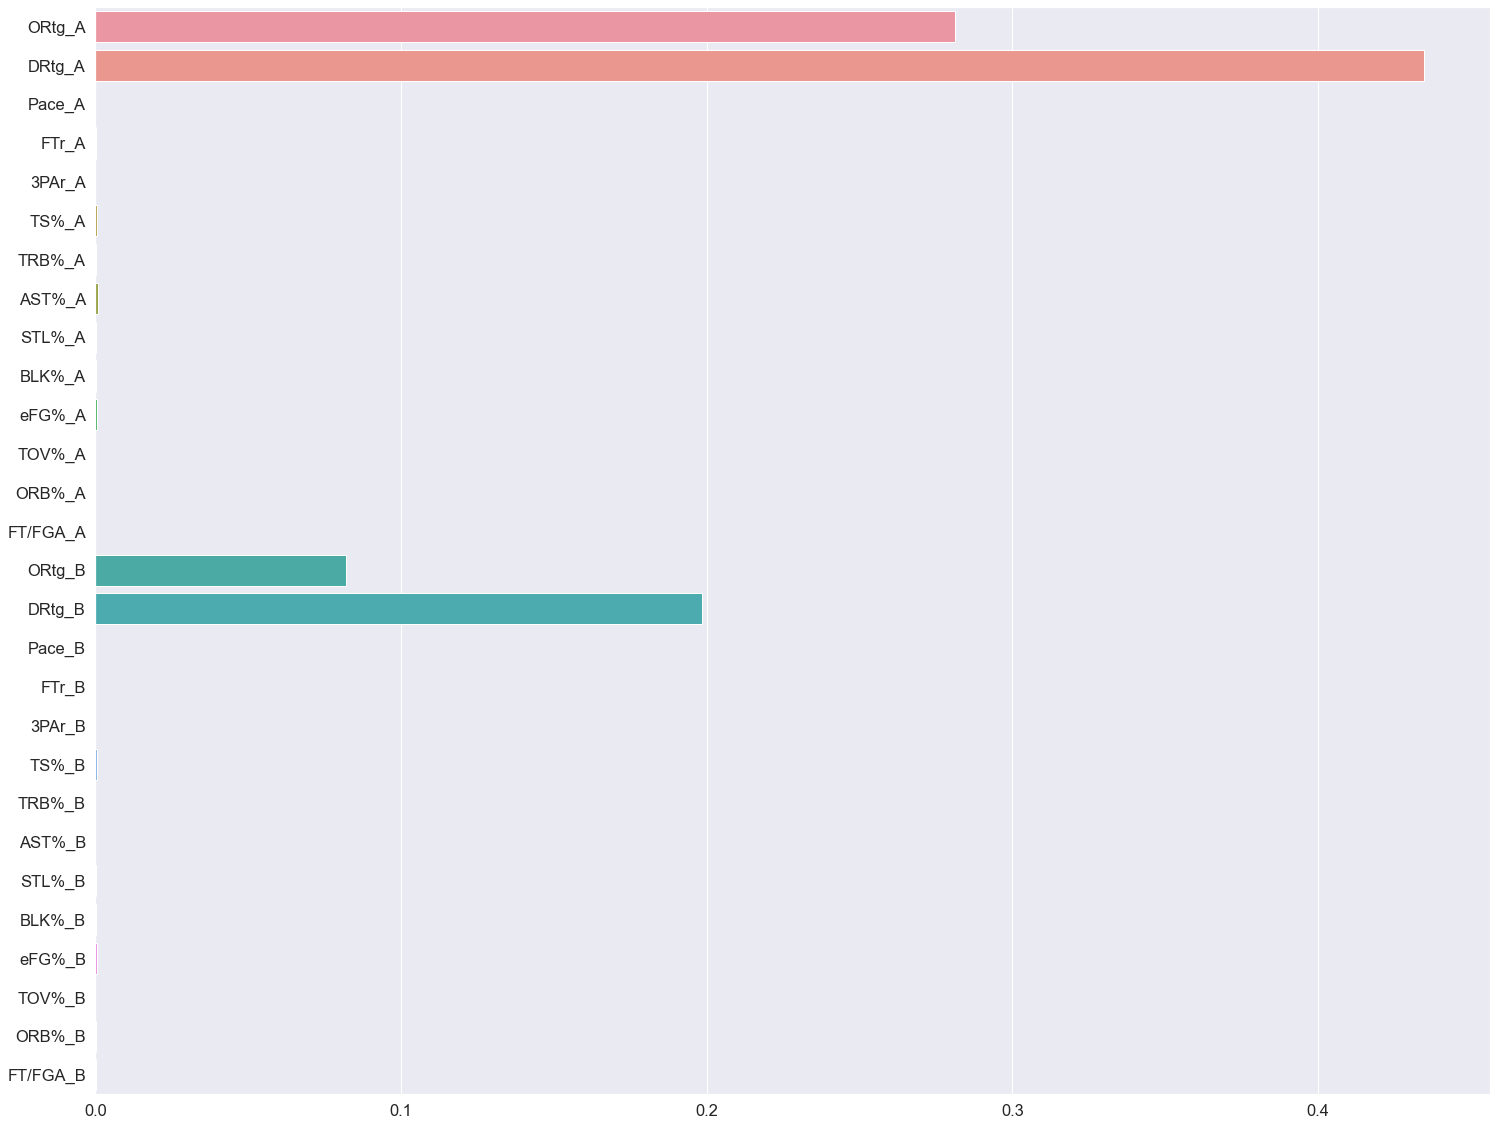

In [23]:
# Check out the feature importances
plt.figure(figsize=(25,20))
sns.barplot(x=d_tree.feature_importances_, y=X.columns)

plt.savefig("btwo_team_features_with_ORtg.png")

In [24]:
print(classification_report(y_test, d_tree.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3260
           1       0.99      1.00      1.00      3299

    accuracy                           1.00      6559
   macro avg       1.00      1.00      1.00      6559
weighted avg       1.00      1.00      1.00      6559



## Check out a second Decision Tree classifier without a bunch of ratings

In [25]:
# Drop the columns that have a higehr correlation with winning, like ORtg, Drtg 
# Leave in eFG
y = games_df['A_Win']
X = games_df.drop(columns=['A_Win', 'Date', 'Team_A', 'Season', 'Team_B', 'Home',\
                          'ORtg_B', 'DRtg_A', 'ORtg_A', 'DRtg_B', 'TS%_A', 'TS%_B'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [26]:
#Construct a decision tree
d_tree = DecisionTreeClassifier()
d_tree.fit(X_train, y_train)
d_tree.feature_importances_

array([0.00506974, 0.01655171, 0.01198864, 0.03994945, 0.01088807,
       0.01772364, 0.01061601, 0.25657476, 0.08040411, 0.00899356,
       0.03665031, 0.00594482, 0.01786301, 0.0099488 , 0.04913178,
       0.0102065 , 0.01532861, 0.01081418, 0.26293112, 0.07698423,
       0.01128804, 0.03414891])

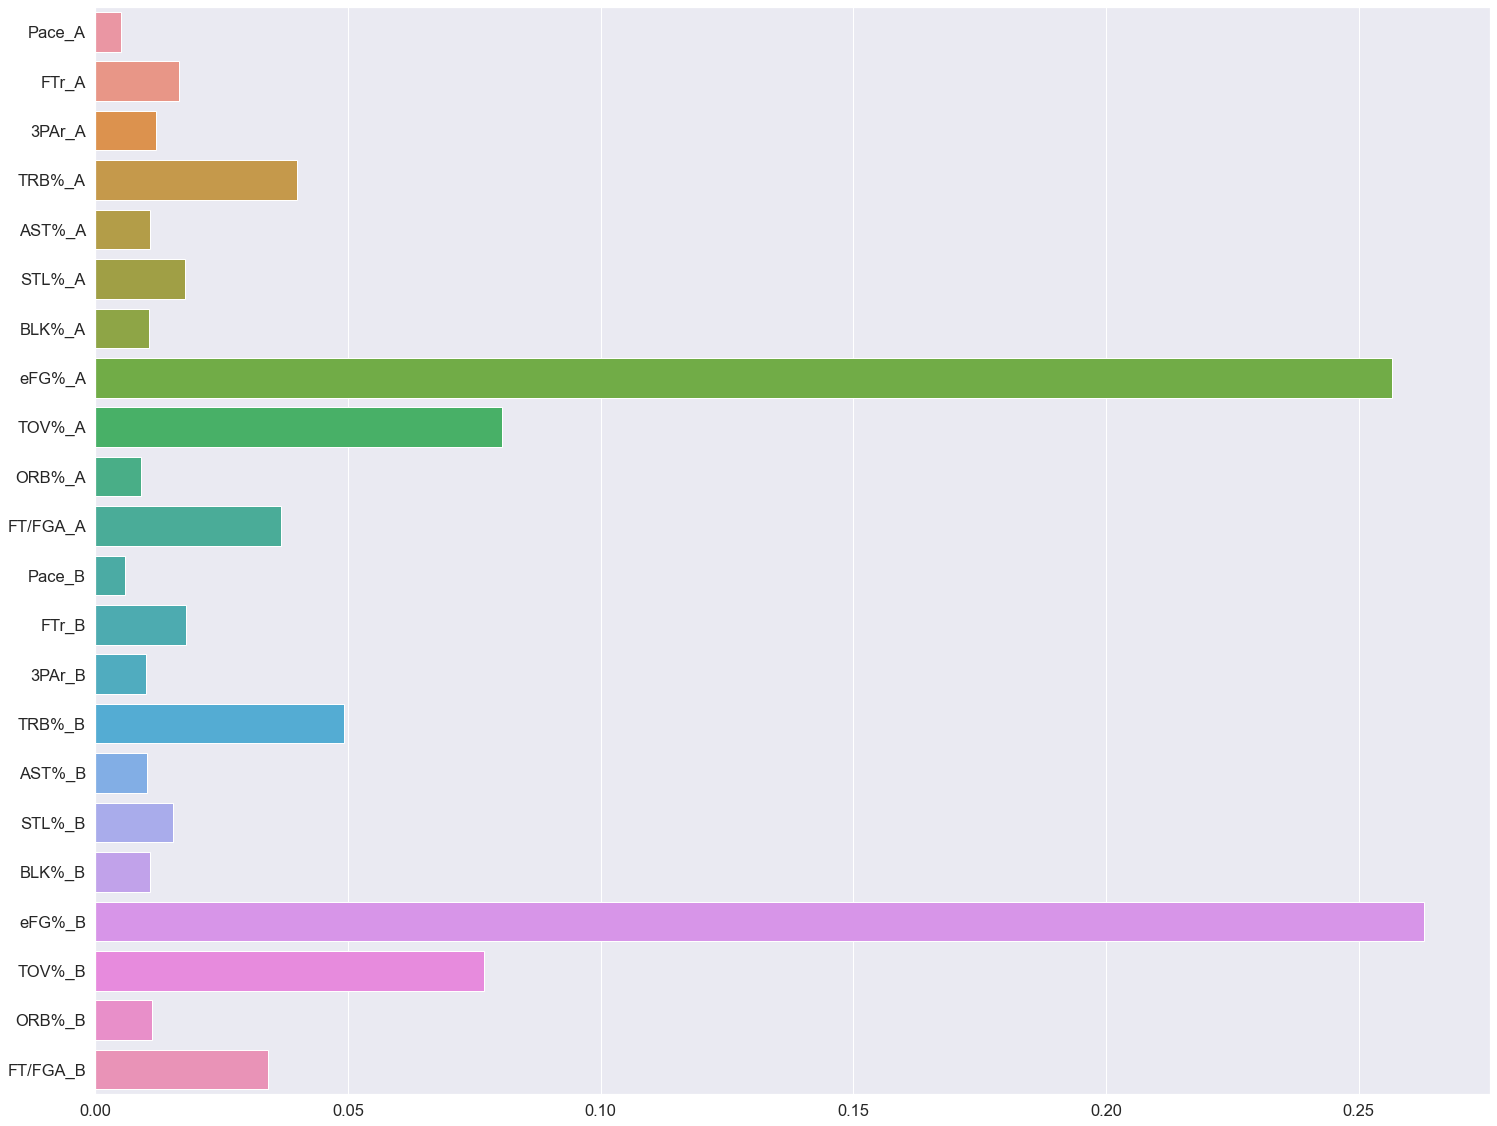

In [27]:
# Check out the feature importances
plt.figure(figsize=(25,20))
sns.barplot(x=d_tree.feature_importances_, y=X.columns)

plt.savefig("two_team_features_updated.png")

In [28]:
classifiers = {
    'Logistic Regression' : LogisticRegression(), 
    'Random Forest' : RandomForestClassifier(), 
    'Support Vector Machine' : SVC(), 
    'K-Nearest Neighbors' : KNeighborsClassifier(), 
    'Decision Tree' : DecisionTreeClassifier(), 
    'XGBoost' : XGBClassifier()
}

In [29]:
# Use a loop to go through each vanilla model
results = pd.DataFrame(columns= ['Train_accuracy', 'Test_accuracy', 'F1_score', 
                                'False_Negative', 'True_Positive'])

for key, value in classifiers.items():
    # Fit models
    value.fit(X_train, y_train)
    train_pred = value.predict(X_train)
    y_pred = value.predict(X_test)
    
    # Get accuracy, f1 score
    train_acc = accuracy_score(y_train, train_pred) * 100
    test_acc = accuracy_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred)
    
    # Get false neg and true positive
    cm = confusion_matrix(y_test, y_pred)
    FN = cm[1][0]
    TP = cm[1][1]
    
    # Add measurements to dataframe
    results.loc[key] = [round(train_acc, 2), round(test_acc, 2), 
                        round(f1, 2), round(FN, 0), round(TP, 0)]

In [54]:
results.sort_values(by= ['F1_score', 'False_Negative'], ascending= False)

plt.savefig("two_team_updated_scores.png")

,Train_accuracy,Test_accuracy,F1_score,False_Negative,True_Positive
XGBoost,99.95,94.54,0.95,196.0,3103.0
RS XGBoost,99.96,94.82,0.95,175.0,3124.0
Random Forest,100.00,90.85,0.91,307.0,2992.0
Random Search Random Forest,99.55,91.05,0.91,290.0,3009.0
Logistic Regression,87.55,87.83,0.88,402.0,2897.0
Support Vector Machine,83.53,84.10,0.84,542.0,2757.0
Decision Tree,81.96,80.36,0.81,579.0,2720.0
K-Nearest Neighbors,81.89,70.97,0.71,963.0,2336.0


## Move forward with a function that gives results after each model run

In [31]:
def get_results(model, model_name):
    train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    # get classification report
    print('{} Classification Report'.format(model_name))
    print(classification_report(y_test, y_pred))
    
    # get confusion matrix
    plot_confusion_matrix(model, X_test, y_test, cmap= "Blues", values_format= '.5g')
    plt.grid(False)
    plt.show()
    
    # get accuracy and F1 scores
    train_acc = accuracy_score(y_train, train_pred) * 100
    test_acc = accuracy_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred)
    
    #get false neg and true positive
    cm = confusion_matrix(y_test, y_pred)
    FN = cm[1][0]
    TP = cm[1][1]
    
    # save measurements into results df
    results.loc[model_name] = [round(train_acc, 2), round(test_acc, 2), 
                               round(f1, 2), round(FN, 0), round(TP, 0)]

# Run some models 

## K-Nearest Neighbors, with scaled data

In [32]:
# Drop the columns that have a higehr correlation with winning, like ORtg, Drtg 
# Leave in TS and eFG
y = games_df['A_Win']
X = games_df.drop(columns=['A_Win', 'Date', 'Team_A', 'Season', 'Team_B', 'Home',\
                          'ORtg_B', 'DRtg_A', 'ORtg_A', 'DRtg_B', 'TS%_A', 'TS%_B'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [33]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

In [34]:
# Instantiate KNeighborsClassifier
clf = KNeighborsClassifier()

# Fit the classifier
clf.fit(scaled_data_train, y_train)

# Predict on the test set
test_preds = clf.predict(scaled_data_test)

In [35]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
print_metrics(y_test, test_preds)

Precision Score: 0.8486307553415589
Recall Score: 0.8548044862079418
Accuracy Score: 0.8502820551913401
F1 Score: 0.8517064331017818


In [36]:
# Find best number for K
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))
    
find_best_k(scaled_data_train, y_train, scaled_data_test, y_test)

Best Value for k: 25
F1-Score: 0.8856711915535446


## Decision Tree

In [37]:
# Create features and labels
y = games_df['A_Win']
X = games_df.drop(columns=['A_Win', 'Date', 'Team_A', 'Season', 'Team_B', 'Home',\
                          'ORtg_B', 'DRtg_A', 'ORtg_A', 'DRtg_B', 'TS%_A', 'TS%_B'], axis=1)

# Split the data, 25/75
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

# Train Decision Tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

#Make predictions for test data
y_preds = clf.predict(X_test)

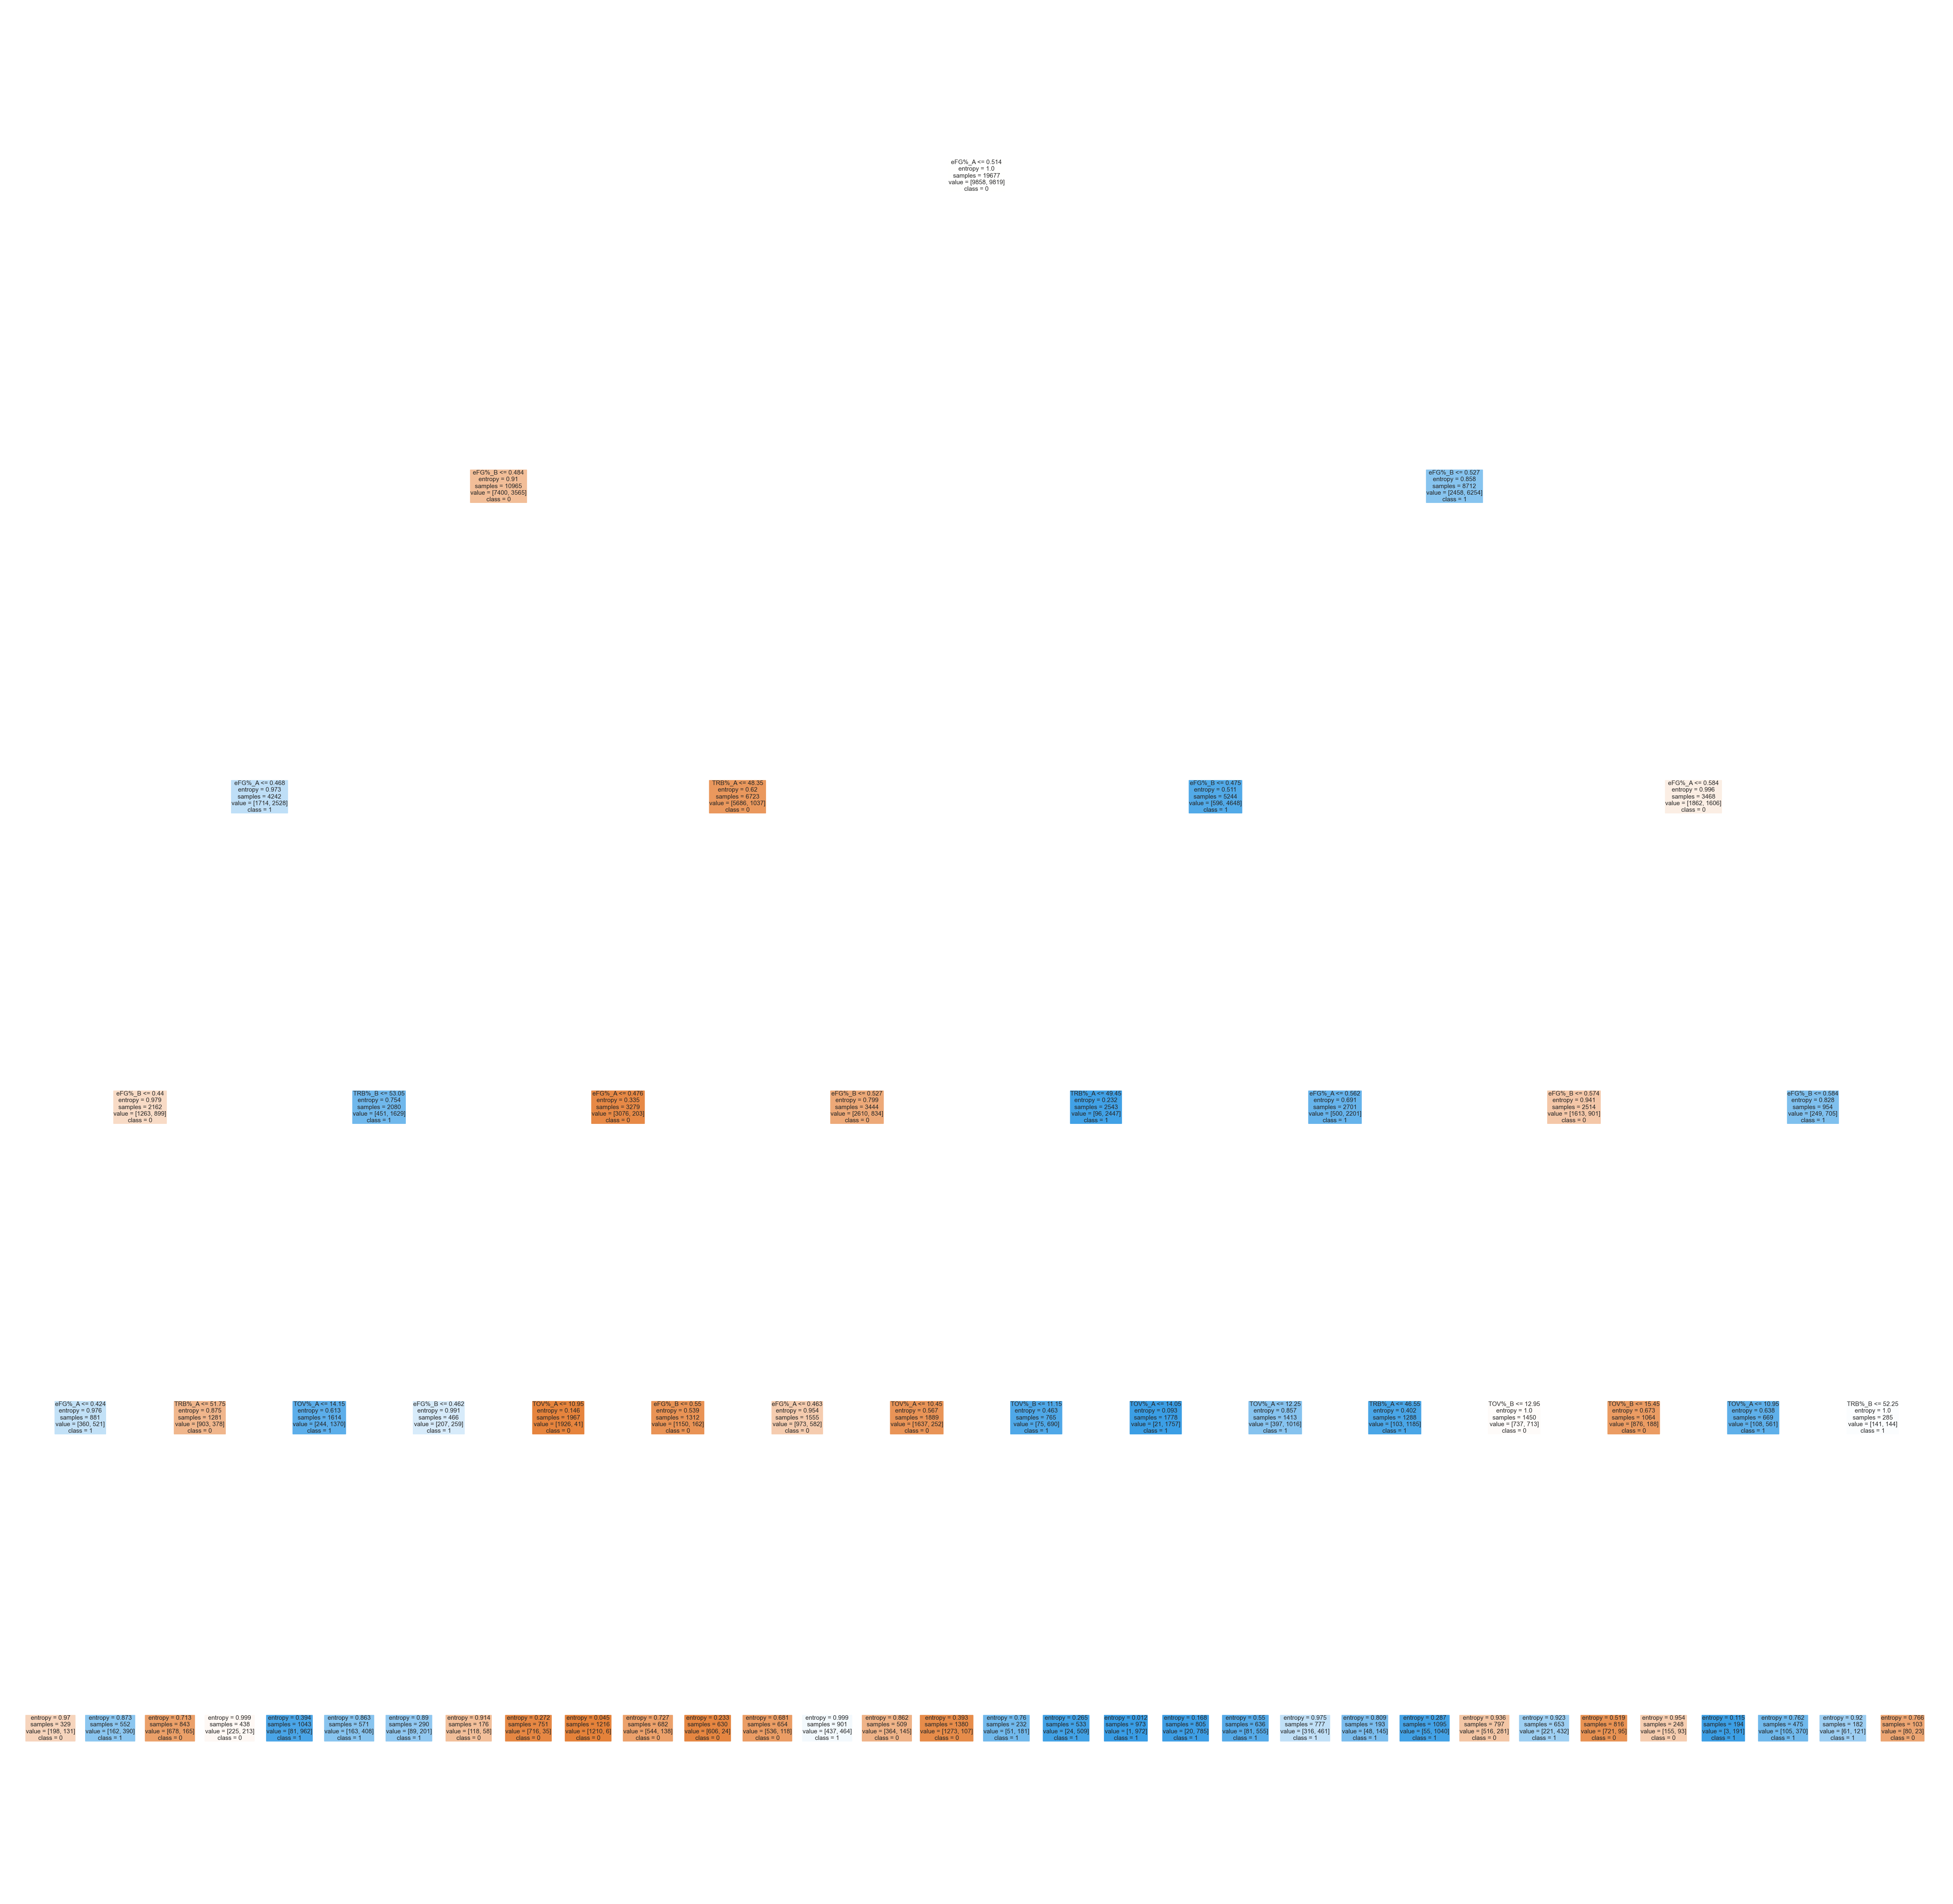

In [38]:
# Instantiate and fit a DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=5)
clf.fit(X_train, y_train)

# Plot and show decision tree
plt.figure(figsize=(12,12), dpi=500)
tree.plot_tree(clf, 
               feature_names=X.columns,
               class_names=np.unique(y).astype('str'),
               filled=True, rounded=True)
plt.show()

Decision Tree Classification Report
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      3260
           1       0.79      0.82      0.81      3299

    accuracy                           0.80      6559
   macro avg       0.80      0.80      0.80      6559
weighted avg       0.80      0.80      0.80      6559



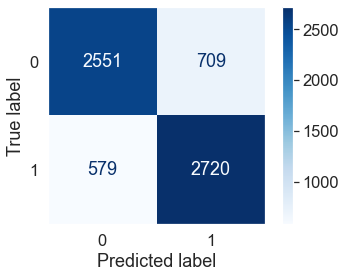

In [39]:
get_results(clf, 'Decision Tree')

## Random Forest, with a grid/parameter search

In [40]:
# Instantiate a classifier
rando = RandomForestClassifier()

# Create a parameter grid
param_grid_rando = {
                 'n_estimators': [10,30,100],
                 'criterion':['gini', 'entropy'],
                 'max_depth': [None, 2, 4, 6],
                 'min_samples_split': [5, 10],
                 'min_samples_leaf': [3,6]
}

In [41]:
# Instantiate Randomized Search
rando_search = RandomizedSearchCV(rando, param_grid_rando, n_iter= 20, scoring= 'f1', 
                           random_state= 42)

# Fit the randomized search model
rando_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 2, 4, 6],
                                        'min_samples_leaf': [3, 6],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [10, 30, 100]},
                   random_state=42, scoring='f1')

In [42]:
# Find best parameters for the Random Forest
rando_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_depth': None,
 'criterion': 'entropy'}

Random Search Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3260
           1       0.91      0.91      0.91      3299

    accuracy                           0.91      6559
   macro avg       0.91      0.91      0.91      6559
weighted avg       0.91      0.91      0.91      6559



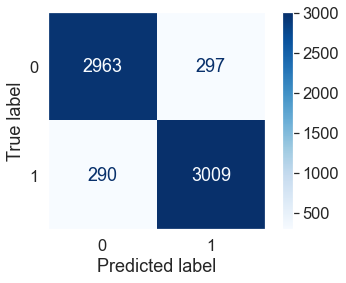

In [43]:
# See model results
get_results(rando_search, 'Random Search Random Forest')

## XGBoost with a parameter search

In [44]:
# Instantiate the XGB classifier
xgb = XGBClassifier()

In [45]:
param_grid_xgb = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4],
    'max_depth': [6],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.5, 0.7, 0.9],
    'n_estimators': [100, 125, 150],
}

In [46]:
RS_xgb = RandomizedSearchCV(xgb, param_grid_xgb, n_jobs= 3, scoring= 'f1', 
                            random_state=42)

In [47]:
RS_xgb.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=N

In [48]:
RS_xgb.best_params_

{'subsample': 0.9,
 'n_estimators': 125,
 'min_child_weight': 3,
 'max_depth': 6,
 'learning_rate': 0.3}

RS XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3260
           1       0.95      0.95      0.95      3299

    accuracy                           0.95      6559
   macro avg       0.95      0.95      0.95      6559
weighted avg       0.95      0.95      0.95      6559



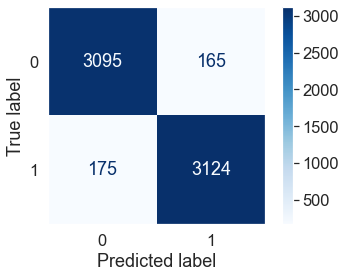

In [49]:
get_results(RS_xgb, 'RS XGBoost')

## Feature Importance for XGBoost

In [50]:
# create DataFrame with feature importance to create nice looking graph
#  using tuned XGBoost model
FeatImp={'feature_names' : X.columns.values, 
         'feature_importance' : RS_xgb.best_estimator_.feature_importances_}
FI_df = pd.DataFrame(FeatImp)
FI_df.sort_values(by= ['feature_importance'], ascending= False, inplace= True)

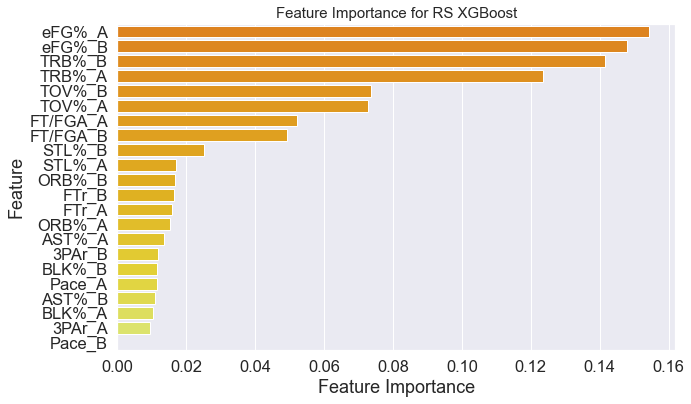

In [56]:
plt.figure(figsize= (10,6))
sns.barplot(x= FI_df['feature_importance'], y= FI_df['feature_names'], 
            palette= 'Wistia_r')
plt.title('Feature Importance for RS XGBoost', fontsize= '15')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

plt.savefig("xgboost_features.png")